# Regression problem using RBF

In [69]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow import keras

from keras.datasets import boston_housing
from keras import Model, layers
from keras.metrics import RootMeanSquaredError
from keras import backend as K

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

import numpy as np
from scipy.spatial.distance import cdist

import time
import sys

import matplotlib.pyplot as plt
%matplotlib inline

## Useful functions

In [70]:
# The radial basis function layer
# x is the input of the layer and c is the centers of the rbf neurons
# The function returns the outputs of the rbf layer as a NxM matrix where N is the length of x and M is the length of c
def rbf_layer(x, c):
    rbf_neurons = np.shape(c)[0]

    # Find sigma
    d_max = cdist(c, c, metric="euclidean").max()
    sigma = d_max / np.sqrt(2 * rbf_neurons)
    
    # Stores the transformed set x after it passes the rbf layer
    transformed_x = np.zeros([np.shape(x)[0], rbf_neurons], dtype=np.float32)

    # Pass the x set through every rbf neuron
    for i, center in enumerate(c):
        # Find the squared norms
        norms = np.linalg.norm((x - center), axis=1) ** 2

        transformed_x[:, i] = np.exp(-norms) / (2 * (sigma))

    return transformed_x

In [71]:
# Function that plots figures based on the history of the training
def loss_acc_plot(history):
    plt.figure()
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.legend()
    plt.title('Loss of train and validation sets')
    
    plt.figure()
    plt.plot(history.history['coeff_determination'], label = 'Train')
    plt.plot(history.history['val_coeff_determination'], label = 'Validation')
    plt.legend()
    plt.title('R squared of train and validation sets')

    plt.figure()
    plt.plot(history.history['root_mean_squared_error'], label='Train')
    plt.plot(history.history['val_root_mean_squared_error'], label='Validation')
    plt.legend()
    plt.title('RMSE of train and validation sets')

    plt.show()

In [72]:
# Function for R squared
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

## Data Preprocessing

In [73]:
# Preparation of boston housing data
(x_train, y_train), (x_test, y_test) = boston_housing.load_data(test_split=0.25)

# Convert to float32.
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
y_train, y_test = np.array(y_train, np.float32), np.array(y_test, np.float32)

# Scale the training and testing data
scaler = MinMaxScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

## Case 1: Number of RBF neurons is the 10% of the training data

In [74]:
# Number of RBF neurons is the 10% of the training data
rbf_neurons = int(0.1*np.shape(y_train)[0])

kmeans_1 = KMeans(n_clusters=rbf_neurons, n_init=10).fit(x_train)
centers = kmeans_1.cluster_centers_

# Pass the train set from the rbf layer
x_train_transformed = rbf_layer(x_train, centers)

In [75]:
model_1 = keras.Sequential([
    keras.layers.Dense(128, input_shape=(rbf_neurons,), activation='relu'),
    keras.layers.Dense(1)
])

model_1.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 128)               4864      
                                                                 
 dense_23 (Dense)            (None, 1)                 129       
                                                                 
Total params: 4,993
Trainable params: 4,993
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
10/10 [==============================] - 1s 27ms/step - loss: 403.7868 - coeff_determination: -4.8178 - root_mean_squared_error: 20.0944 - val_loss: 325.6255 - val_coeff_determination: -2.1105 - val_root_mean_squared_error: 18.0451
Epoch 2/100
10/10 [==============================] - 0s 8ms/step - loss: 126.9717 - coeff_determination: -0.6604 - root_mean_squared_error: 11.2682 - val_loss: 202.0392 - val_coeff_determination: -0.7129 - val_root_mean_squared_error: 14.2140
Epoch 3/100
10/10 [==============================] - 0s 8ms/step - loss: 96.1084 - coeff_determination: -0.2463 - root_mean_squared_error: 9.8035 - val_loss: 189.3763 - val_coeff_determination: -0.6447 - val_root_mean_squared_error: 13.7614
Epoch 4/100
10/10 [==============================] - 0s 8ms/step - loss: 92.5685 - coeff_determination: -0.4191 - root_mean_squared_error: 9.6213 - val_loss: 186.0666 - val_coeff_determination: -0.5748 - val_root_mean_squared_error: 13.6406
Epoch 5/100
10/10 [============

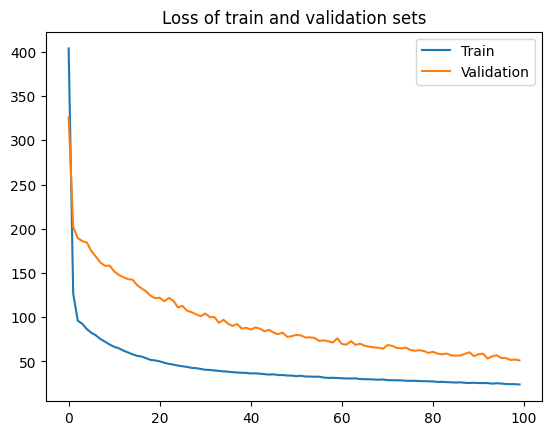

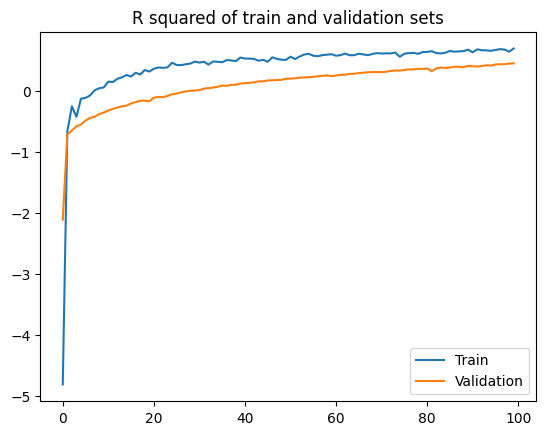

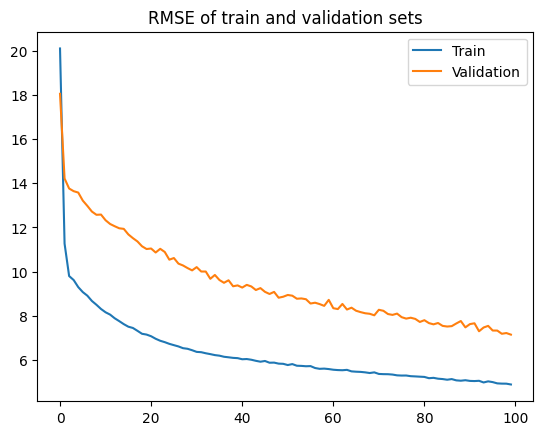

Training time: 9.042616128921509 seconds


In [76]:
optim = keras.optimizers.SGD(learning_rate=0.001)
loss_func = keras.losses.MeanSquaredError()

model_1.compile(optimizer=optim, loss=loss_func, metrics=[coeff_determination, RootMeanSquaredError()])

st = time.time()

history = model_1.fit(x_train_transformed, y_train, epochs=100, validation_split=0.2)

end = time.time()

loss_acc_plot(history)

print('Training time:', end-st, 'seconds')

## Case 2: Number of RBF neurons is the 50% of the training data

In [77]:
# Number of RBF neurons is the 10% of the training data
rbf_neurons = int(0.5*np.shape(y_train)[0])

kmeans_2 = KMeans(n_clusters=rbf_neurons, n_init=10).fit(x_train)
centers = kmeans_2.cluster_centers_

# Pass the train set from the rbf layer
x_train_transformed = rbf_layer(x_train, centers)

In [78]:
model_2 = keras.Sequential([
    keras.layers.Dense(128, input_shape=(rbf_neurons,), activation='relu'),
    keras.layers.Dense(1)
])

model_2.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 128)               24320     
                                                                 
 dense_25 (Dense)            (None, 1)                 129       
                                                                 
Total params: 24,449
Trainable params: 24,449
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
10/10 [==============================] - 1s 29ms/step - loss: 164.3746 - coeff_determination: -1.4343 - root_mean_squared_error: 12.8209 - val_loss: 188.6909 - val_coeff_determination: -0.6354 - val_root_mean_squared_error: 13.7365
Epoch 2/100
10/10 [==============================] - 0s 8ms/step - loss: 81.1406 - coeff_determination: -0.1216 - root_mean_squared_error: 9.0078 - val_loss: 214.6763 - val_coeff_determination: -0.9437 - val_root_mean_squared_error: 14.6518
Epoch 3/100
10/10 [==============================] - 0s 8ms/step - loss: 73.1782 - coeff_determination: 0.0722 - root_mean_squared_error: 8.5544 - val_loss: 173.7827 - val_coeff_determination: -0.5413 - val_root_mean_squared_error: 13.1827
Epoch 4/100
10/10 [==============================] - 0s 7ms/step - loss: 73.9708 - coeff_determination: 0.0676 - root_mean_squared_error: 8.6006 - val_loss: 160.6958 - val_coeff_determination: -0.4333 - val_root_mean_squared_error: 12.6766
Epoch 5/100
10/10 [================

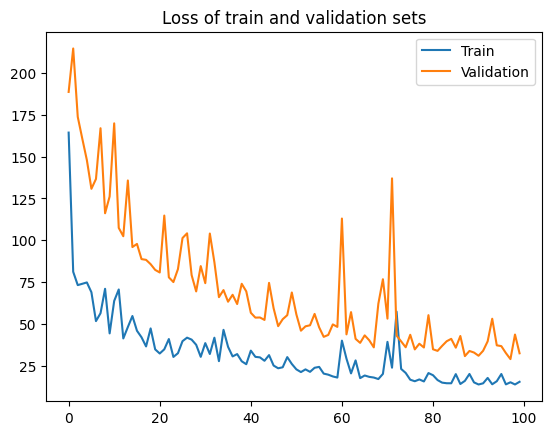

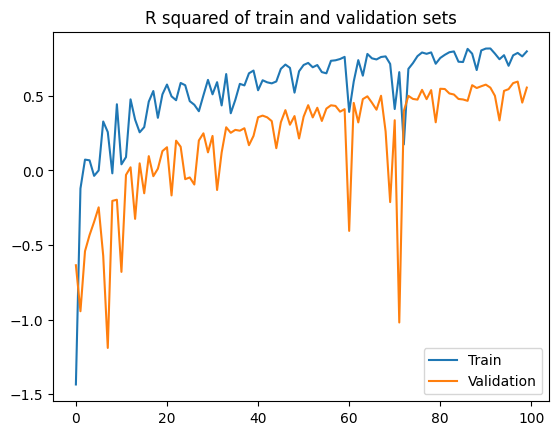

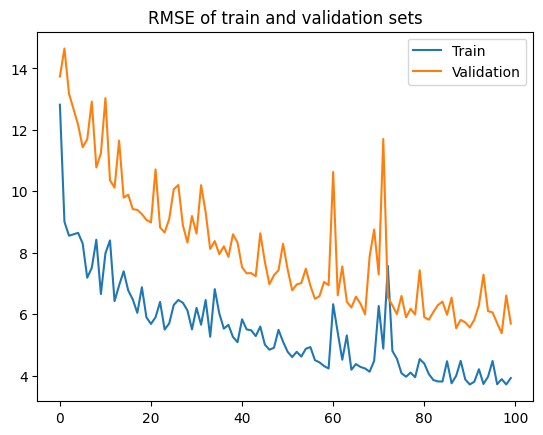

Training time: 9.363486528396606 seconds


In [79]:
optim = keras.optimizers.SGD(learning_rate=0.001)
loss_func = keras.losses.MeanSquaredError()

model_2.compile(optimizer=optim, loss=loss_func, metrics=[coeff_determination, RootMeanSquaredError()])

st = time.time()

history = model_2.fit(x_train_transformed, y_train, epochs=100, validation_split=0.2)

end = time.time()

loss_acc_plot(history)

print('Training time:', end-st, 'seconds')

## Case 3: Number of RBF neurons is the 90% of the training data

In [80]:
# Number of RBF neurons is the 10% of the training data
rbf_neurons = int(0.9*np.shape(y_train)[0])

kmeans_3 = KMeans(n_clusters=rbf_neurons, n_init=10).fit(x_train)
centers = kmeans_3.cluster_centers_

# Pass the train set from the rbf layer
x_train_transformed = rbf_layer(x_train, centers)

In [81]:
model_3 = keras.Sequential([
    keras.layers.Dense(128, input_shape=(rbf_neurons,), activation='relu'),
    keras.layers.Dense(1)
])

model_3.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 128)               43776     
                                                                 
 dense_27 (Dense)            (None, 1)                 129       
                                                                 
Total params: 43,905
Trainable params: 43,905
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
10/10 [==============================] - 1s 44ms/step - loss: 375.1816 - coeff_determination: -3.7461 - root_mean_squared_error: 19.3696 - val_loss: 230.6725 - val_coeff_determination: -1.3699 - val_root_mean_squared_error: 15.1879
Epoch 2/100
10/10 [==============================] - 0s 8ms/step - loss: 167.7823 - coeff_determination: -1.5811 - root_mean_squared_error: 12.9531 - val_loss: 416.2899 - val_coeff_determination: -3.5079 - val_root_mean_squared_error: 20.4032
Epoch 3/100
10/10 [==============================] - 0s 7ms/step - loss: 167.1332 - coeff_determination: -1.1170 - root_mean_squared_error: 12.9280 - val_loss: 169.0151 - val_coeff_determination: -0.5472 - val_root_mean_squared_error: 13.0006
Epoch 4/100
10/10 [==============================] - 0s 8ms/step - loss: 93.9846 - coeff_determination: -0.3457 - root_mean_squared_error: 9.6946 - val_loss: 153.7789 - val_coeff_determination: -0.4140 - val_root_mean_squared_error: 12.4008
Epoch 5/100
10/10 [==========

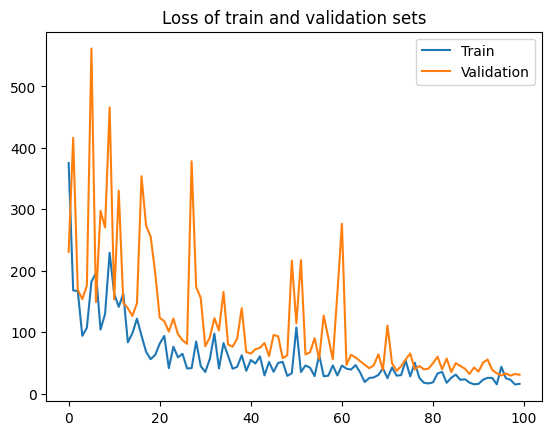

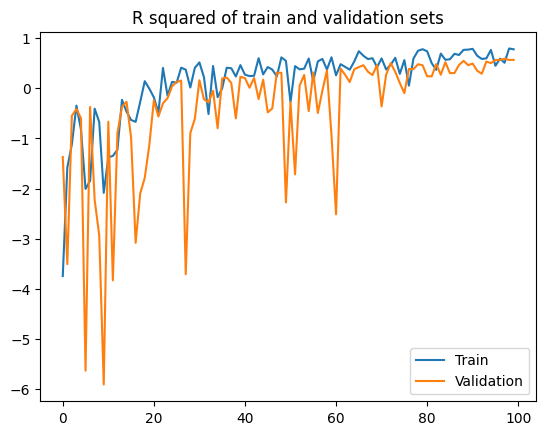

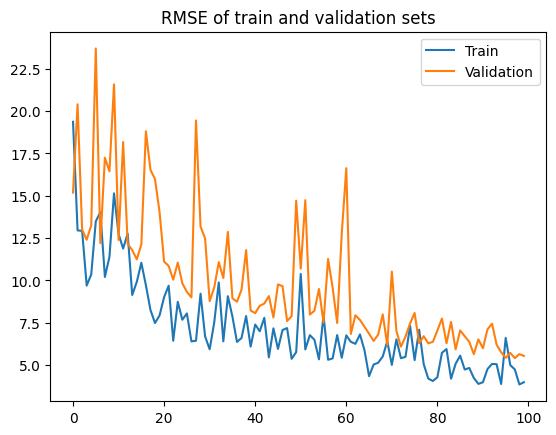

Training time: 11.924667119979858 seconds


In [82]:
optim = keras.optimizers.SGD(learning_rate=0.001)
loss_func = keras.losses.MeanSquaredError()

model_3.compile(optimizer=optim, loss=loss_func, metrics=[coeff_determination, RootMeanSquaredError()])

st = time.time()

history = model_3.fit(x_train_transformed, y_train, epochs=100, validation_split=0.2)

end = time.time()

loss_acc_plot(history)

print('Training time:', end-st, 'seconds')